In [1]:
# import cProfile
import collections
import datetime
import math

import os
# import sys
import time

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, RobustScaler

import random

import gc

pd.options.display.float_format = "{:.2f}".format
# plt.rcParams.update({'font.size': 18})
format = '%d/%m/%Y %H:%M'

# Load data

Load all data required.

In [2]:
def load_file(data_path, msg):
    if msg != '':
        txt = msg + ' - ' + data_path
    else:
        txt = data_path

    if os.path.exists(data_path):
        print('Loaded: ' + txt)
        with open(data_path, 'rb') as f:
            file_loaded = pickle.load(f)
        return file_loaded
    else:
        print('File not found: ' + txt)

In [3]:
# Load all data

playlists_train = load_file(
    os.getcwd() + '\\data\\processed\\3_playlists_dict_train.pkl',
    'Playlists dictionary (training)')
playlists_test = load_file(
    os.getcwd() + '\\data\\processed\\3_playlists_dict_test.pkl',
    'Playlists dictionary (test)')
print('Playlist - training set: ' + str(len(playlists_train)))
print('Playlist - test set: ' + str(len(playlists_test)))
print()

tracks_dict_train = load_file(
    os.getcwd() + '\\data\\processed\\4_tracks_dict_train.pkl',
    'Tracks dictionary (training)')
tracks_dict_test = load_file(
    os.getcwd() + '\\data\\processed\\4_tracks_dict_test.pkl',
    'Tracks dictionary (test)')
print('Tracks - training set: ' + str(len(tracks_dict_train)))
print('Tracks - test set: ' + str(len(tracks_dict_test)))
print()

artists_dict_train = load_file(
    os.getcwd() + '\\data\\processed\\5_artists_dict_train.pkl',
    'Artist dictionary (training)')
artists_dict_test = load_file(
    os.getcwd() + '\\data\\processed\\5_artists_dict_test.pkl',
    'Artist dictionary (test)')
print('Artist - training set: ' + str(len(artists_dict_train)))
print('Artist - test set: ' + str(len(artists_dict_test)))
print()

albums_dict_train = load_file(
    os.getcwd() + '\\data\\processed\\6_albums_dict_train.pkl',
    'Albums dictionary (training)')
albums_dict_test = load_file(
    os.getcwd() + '\\data\\processed\\6_albums_dict_test.pkl',
    'Albums dictionary (test)')
print('Albums - training set: ' + str(len(albums_dict_train)))
print('Albums - test set: ' + str(len(albums_dict_test)))
print()

Loaded: Playlists dictionary (training) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\3_playlists_dict_train.pkl
Loaded: Playlists dictionary (test) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\3_playlists_dict_test.pkl
Playlist - training set: 1243
Playlist - test set: 533

Loaded: Tracks dictionary (training) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\4_tracks_dict_train.pkl
Loaded: Tracks dictionary (test) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\4_tracks_dict_test.pkl
Tracks - training set: 63699
Tracks - test set: 31183

Loaded: Artist dictionary (training) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\5_artists_dict_train.pkl
Loaded: Artist dictionary (test) - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\5_artists_dict_test.pkl
Artist - training set: 22639
Artist - test set: 12780

Loaded: Albums dictionary

In [4]:
# All tracks
data_path = os.getcwd() + '\\data\\processed\\4_tracks_dict.pkl'
txt = 'All tracks as a dictionary - ' + data_path

if os.path.exists(data_path):
    print('Loaded: ' + txt)
    with open(data_path, 'rb') as f:
        tracks_dict = pickle.load(f)
else:
#     print('File not found: ' + txt)
    tracks_dict = dict_all_tracks(data_path,playlists_dict)

print(len(tracks_dict))

Loaded: All tracks as a dictionary - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\4_tracks_dict.pkl
85458


In [5]:
# All artists
data_path = os.getcwd() + '\\data\\processed\\5_artists_dict.pkl'
txt = 'All artists as a dictionary - ' + data_path

if os.path.exists(data_path):
    print('Loaded: ' + txt)
    with open(data_path, 'rb') as f:
        artists_dict = pickle.load(f)
else:
#     print('File not found: ' + txt)
    artists_dict = dict_all_artists(data_path,playlists_dict)
    
print(len(artists_dict))

Loaded: All artists as a dictionary - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\5_artists_dict.pkl
28669


In [6]:
# All albums
data_path = os.getcwd() + '\\data\\processed\\6_albums_dict.pkl'
txt = 'All albums as a dictionary - ' + data_path

if os.path.exists(data_path):
    print('Loaded: ' + txt)
    with open(data_path, 'rb') as f:
        albums_dict = pickle.load(f)
else:
#     print('File not found: ' + txt)
    albums_dict = dict_all_albums(data_path,playlists_dict)
print(len(albums_dict))

Loaded: All albums as a dictionary - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\6_albums_dict.pkl
62095


##### Create data frames to perform analysis

In [7]:
gc.collect()
df_playlists_train = playlists_train.T
print("df_playlists_train:", df_playlists_train.shape)

df_playlists_test = playlists_test.T
print("df_playlists_test:", df_playlists_test.shape)

df_tracks_train = pd.DataFrame.from_dict(tracks_dict_train, orient='index')
df_tracks_train = df_tracks_train.T
print("df_tracks_train:", df_tracks_train.shape)

df_tracks_test = pd.DataFrame.from_dict(tracks_dict_test, orient='index')
df_tracks_test = df_tracks_test.T
print("df_tracks_test:", df_tracks_test.shape)

df_artists_train = pd.DataFrame.from_dict(artists_dict_train, orient='index')
df_artists_train = df_artists_train.T
print("df_artists_train:", df_artists_train.shape)

df_artists_test = pd.DataFrame.from_dict(artists_dict_test, orient='index')
df_artists_test = df_artists_test.T
print("df_artists_test:", df_artists_test.shape)

df_albums_train = pd.DataFrame.from_dict(albums_dict_train, orient='index')
df_albums_train = df_albums_train.T
print("df_albums_train:", df_albums_train.shape)

df_albums_test = pd.DataFrame.from_dict(albums_dict_test, orient='index')
df_albums_test = df_albums_test.T
print("df_albums_test:", df_albums_test.shape)

df_playlists_train: (4, 1243)
df_playlists_test: (4, 533)
df_tracks_train: (7, 63699)
df_tracks_test: (7, 31183)
df_artists_train: (3, 22639)
df_artists_test: (3, 12780)
df_albums_train: (4, 46688)
df_albums_test: (4, 24258)


# Co-occurrence matrix

## Tracks co-occurrence matrix

In [8]:
def co_occurrence_matrix_tracks(playlists_dict, tracks_dict):
    matrix = {}
    for i, item in enumerate(tracks_dict):
        tracks_matched = []
        for j, playlist_id in enumerate(tracks_dict[item]['in_playlist']):
            for tr, track in enumerate(playlists_dict[playlist_id]['tracks']):
                tracks_matched.append(track['id'])
        counter = collections.Counter(tracks_matched)
        b = pd.DataFrame.from_dict(counter, orient='index', columns=['cnt'])
        b = b.sort_values('cnt', ascending=False)

        min_max = MinMaxScaler()
        b['count_scaled'] = min_max.fit_transform(b[['cnt']])
        b['rank'] = b['count_scaled'].rank(method='average', ascending=False)

        matrix.update({item: b})
    return (matrix)

## Artists co-occurrence matrix

In [9]:
def co_occurrence_matrix_artists(playlists_dict, artists_dict):
    matrix = {}
    for i, item in enumerate(artists_dict):
        artist_matched = []
        for j, playlist_id in enumerate(artists_dict[item]['in_playlist']):
            for tr, track in enumerate(playlists_dict[playlist_id]['tracks']):
                for a, artist in enumerate(track['artists']):
                    artist_matched.append(artist['id'])
        counter = collections.Counter(artist_matched)
        b = pd.DataFrame.from_dict(counter, orient='index', columns=['cnt'])
        b = b.sort_values('cnt', ascending=False)

        min_max = MinMaxScaler()
        b['count_scaled'] = min_max.fit_transform(b[['cnt']])
        b['rank'] = b['count_scaled'].rank(method='average', ascending=False)

        matrix.update({item: b})
    return (matrix)

## Albums co-occurrence matrix

In [10]:
def co_occurrence_matrix_albums(playlists_dict, albums_dict):
    matrix = {}
    for i, item in enumerate(albums_dict):
        albums_matched = []
        for j, playlist_id in enumerate(albums_dict[item]['in_playlist']):
            for tr, track in enumerate(playlists_dict[playlist_id]['tracks']):
                albums_matched.append(track['album']['id'])
        counter = collections.Counter(albums_matched)
        b = pd.DataFrame.from_dict(counter, orient='index', columns=['cnt'])
        b = b.sort_values('cnt', ascending=False)

        min_max = MinMaxScaler()
        b['count_scaled'] = min_max.fit_transform(b[["cnt"]])
        b["rank"] = b['count_scaled'].rank(method='average', ascending=False)

        matrix.update({item: b})
    return (matrix)

##  Create all co-ocurrence matrix

In [11]:
def co_ocurrence(playlist, df, data_path, txt):
    # check if data extraction already exists then load if it exists, otherwise run query
    if os.path.exists(data_path):
        print('Co-occurrence ' + txt + ' - Loaded: ' + data_path)
        # load file only if the next step was not executed (getting tracks)
        with open(data_path, 'rb') as f:
            co_occurrence = pickle.load(f)
    else:
        print('Co-occurrence ' + txt + ' - Saved: ' + data_path)
        # list of all user ids (UID) and playlist ids (PID)
        uid_pid_raw = []

        if txt == 'tracks':
            co_occurrence = co_occurrence_matrix_tracks(playlist, df)
        elif txt == 'artists':
            co_occurrence = co_occurrence_matrix_artists(playlist, df)
        elif txt == 'albums':
            co_occurrence = co_occurrence_matrix_albums(playlist, df)

        # Save the data
        with open(data_path, 'wb') as f:
            pickle.dump(co_occurrence, f)

    len(co_occurrence)
    # co_occurrence_tracks['1MJ5f5EYBC92ADD6xcz7nb']
    return co_occurrence

In [12]:
gc.collect()

co_occurrence_tracks_train = co_ocurrence(
    df_playlists_train, df_tracks_train,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_tracks_train.pkl',
    'tracks')
# co_occurrence_tracks_test = co_ocurrence(
#     df_playlists_test, df_tracks_test,
#     os.getcwd() + '\\data\\processed\\7_co_occurrence_tracks_test.pkl',
#     'tracks')

co_occurrence_artists_train = co_ocurrence(
    df_playlists_train, df_artists_train,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_artists_train.pkl',
    'artists')
# co_occurrence_artists_test = co_ocurrence(
#     df_playlists_test, df_artists_test,
#     os.getcwd() + '\\data\\processed\\7_co_occurrence_artists_test.pkl',
#     'artists')

co_occurrence_albums_train = co_ocurrence(
    df_playlists_train, df_albums_train,
    os.getcwd() + '\\data\\processed\\7_co_occurrence_albums_train.pkl',
    'albums')
# co_occurrence_albums_test = co_ocurrence(
#     df_playlists_test, df_albums_test,
#     os.getcwd() + '\\data\\processed\\7_co_occurrence_albums_test.pkl',
#     'albums')

print("co_occurrence_tracks_train:", len(co_occurrence_tracks_train))
# print("co_occurrence_tracks_test:", len(co_occurrence_tracks_test))
print("co_occurrence_artists_train:", len(co_occurrence_artists_train))
# print("co_occurrence_artists_test:", len(co_occurrence_artists_test)
print("co_occurrence_albums_train:", len(co_occurrence_albums_train))
# print("co_occurrence_albums_test:", len(co_occurrence_albums_test))

Co-occurrence tracks - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_tracks_train.pkl
Co-occurrence artists - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_artists_train.pkl
Co-occurrence albums - Loaded: C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\7_co_occurrence_albums_train.pkl
co_occurrence_tracks_train: 63699
co_occurrence_artists_train: 22639
co_occurrence_albums_train: 46688


# Model

In [13]:
def prepare_inputs(playlist_trx, trx_train, trx_test, fraction):
    trx = playlist_trx.tracks
    n = int((len(trx) + 1) * fraction)

    ids = pd.DataFrame(trx).id  # ids of the original playlist
    selected_ids = random.sample(ids.values.tolist(), n)

    db = trx_train.T
    trx_available = db[~db.id.isin(selected_ids)]

    reference_trx = trx_test.T[trx_test.T.id.isin(selected_ids)]
    expected_trx = trx_test.T[~trx_test.T.id.isin(selected_ids)
                              & trx_test.T.id.isin(ids)]

    return trx_available, reference_trx, expected_trx

## Random

In [565]:
def get_trk_rnd(playlist_trx, trx_train, trx_test, ref_fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, ref_fraction)
        
    select = random.sample(trx_available['id'].values.tolist(), len(expected_trx))
    
    print(select)
#     print(type(select))
    selected_trx = trx_available[trx_available.id.isin(select)]

    return reference_trx, expected_trx, selected_trx

reference_trx, expected_trx, selected_trx = get_trk_rnd(
    df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
    df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

['6KlX7QCrOD9qLQVO1FEgSa', '6DzjZ1LiJpGahHZaMmbGML', '32jHB7W9b08OTorAqR0cJo', '6HRa9FtX8ifjQmA3XFBXan', '0R9pry9kx9vAgwygHCUywR', '7nionv2ijjqUlg9m5iWPTc', '2pv8oYIvio5HQueEs0byrt', '4jyU03J2YOhRxgOHit2auK', '1jZRJKE7GZdiZzVgMS9mv2', '5w22WqfjUJ6OsDBVj9ub5u', '23EquxExXkNmGCCY96P0Iu', '5gcOQlB2n0cxdOOPKRQZBj', '4BY6dDtUBweniXJXnd13Ek', '4Y7FCCc3LvDxfzLjXJgi0v', '1x1EpeiOgliXheTFo2apzy', '5Ql3GqAhahKVhW4GyU59QB', '2nWjhmRImt6LScZIPQMBnM', '25r9whP3KOMLSCtGAM6HON', '37LePO4ZsI3Rh2PtmSSfA4', '6E4DqnxPVMoVrtOyf0DJhG', '7sehRHafpyOc063yc6wYv1', '4mx3kmZZwexQJ1FPxLghpc', '5oyCIQWuSgFB25yA66AIcG', '56f5GO8ir5ucrcQ00k4a8t', '6ey1X2kgEosYVXO9b35wZo', '1jjA9YFzvsmbmy08EaYdY3', '1V7H0FaVShX03W88jBsZcY', '19XuIC3pWHPA0P7uWBheX4', '5CSEaABQkS1hoLza0IpK2r', '3JdwGk8j7lHN5qdzJZklam', '5EuAj9nZiWRKeBkgxMXsW4', '1o1yoF3LSJVdYAkT60730Z', '13xxBnXOuiBxVxJI458B0i', '1ymNYpCCZqXdGG5mpBSWJF', '3VoQDi87LnR500mgLkTtgW', '7dEztoOcmsafZLM2GSPbna', '09Redp0z2ZsZGyJrBqhklP', '14defTisxg0wLogdzxTAAJ', '6IgUSKxsyl

## Stratified selection

In [15]:
# Calculate the tracks frequency
def define_trx_freq(db):
    data_path = os.getcwd() + '\\data\\processed\\8_tracks_frequency.pkl'
    txt = 'Tracks frequency - ' + data_path
    if os.path.exists(data_path):
        print('Loaded: ' + txt)
        with open(data_path, 'rb') as f:
            tracks_frequency = pickle.load(f)
            return tracks_frequency
    else:
        tracks_frequency = pd.DataFrame(
            columns=['track_id', 'cnt', 'cum_sum', 'cum_perc'])

        for t, trk in enumerate(db):
            if t % 100 == 0:
                print("%s - %d/%d - LEN: %d" %
                      (datetime.datetime.now().strftime(format), t, len(db),
                       len(tracks_frequency)))

            df = db[trk]
            df = df[df.index != trk]
            tracks_frequency = tracks_frequency.append(
                {
                    'track_id': trk,
                    'cnt': df['cnt'].sum()
                }, ignore_index=True)

        tracks_frequency = tracks_frequency.sort_values(ascending=False,
                                                        by='cnt')
        tracks_frequency['cum_sum'] = tracks_frequency['cnt'].cumsum()
        tracks_frequency['cum_perc'] = 100 * tracks_frequency[
            'cum_sum'] / tracks_frequency['cnt'].sum()

        print('Saved: ' + txt)
        with open(data_path, 'wb') as f:
            pickle.dump(tracks_frequency, f)

        return tracks_frequency

In [16]:
tracks_frequency = define_trx_freq(co_occurrence_tracks_train)
print(len(tracks_frequency))

Loaded: Tracks frequency - C:\Users\map_f\OneDrive\Documents\GitHub\Follow_the_beat\data\processed\8_tracks_frequency.pkl
63699


In [585]:
def get_trk_strata(playlist_trx, trx_train, trx_test, ref_fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, ref_fraction)
    
    trx_freq = tracks_frequency[tracks_frequency.track_id.isin(trx_available['id'])]
    
    select = trx_freq.drop(trx_freq.index)

    while len(select) < len(expected_trx)*2:
        rnd = random.uniform(0, 1)
        for i, c in enumerate(trx_freq.cum_perc):
            if rnd <= c:
                select = select.append(trx_freq.iloc[i])
                select = select.drop_duplicates()
                break
    
#     print(select)
#     print(type(select))

    select = select[~select.track_id.isin(reference_trx['id'])]
    select = select.reset_index()
    select = select.iloc[0:len(expected_trx)]['track_id']
    
    selected_trx = trx_available[trx_available.id.isin(select)]
    
    return reference_trx, expected_trx, selected_trx

# reference_trx, expected_trx, selected_trx = get_trk_strata(
#     df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
#     df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

## Album

In [542]:
def get_tracks_from_playlist(pid):
    p = playlists_train.loc[pid].tracks
    pid = pd.DataFrame(p)
#     print(pid)
    return pid
# a = get_tracks_from_playlist('5mveLg9twuCna0WwuzvXch')

In [576]:
def get_trk_album(playlist_trx, trx_train, trx_test, ref_fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, ref_fraction)
    
    select = []
    for d in range(1,3):
        for t, cur_trk in enumerate(reference_trx.T):
            aid = reference_trx.loc[cur_trk].album['id']
        #     print(t, 'tid:', cur_trk, 'aid: ', aid)
            if aid in albums_dict_train.keys():
                co_ocur_aid = co_occurrence_albums_train[aid].iloc[1].name
        #         print('co_ocur aid:', co_ocur_aid)
                playlist_id = random.sample(albums_dict_train[co_ocur_aid]['in_playlist'], 1)[0]
#                 print(playlist_id)
                trx = get_tracks_from_playlist(playlist_id)
                aux = random.sample(set(get_tracks_from_playlist(playlist_id).id), 1)[0]
            else:
#                 print('RND')
                aux = random.sample(trx_available['id'].values.tolist(), 1)[0]
#                 print(aux)
            select.append(aux)

#     print(select)
#     print(type(select))
    
    select = pd.DataFrame(select,columns=['id'])
#     print(select)
#     print(type(select))
    
    select = select[~select.id.isin(reference_trx['id'])]
    select = select.reset_index()
    select = select.iloc[0:len(expected_trx)]['id']
    
    selected_trx = trx_available[trx_available.id.isin(select)]
    
    return reference_trx, expected_trx, selected_trx


reference_trx, expected_trx, selected_trx = get_trk_album(
    df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
    df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

In [65]:
trx_available, reference_trx, expected_trx = prepare_inputs(df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train, df_tracks_test, .5)

len(trx_available), len(reference_trx), len(expected_trx)

# reference_trx, expected_trx, selected_trx = get_trk_strata(
#             df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train, df_tracks_test,
#             .5)

(63651, 50, 50)

## Artist

In [624]:
aid = reference_trx.loc['7uzmGiiJyRfuViKKK3lVmR'].artists[0]['id']
aid

'4GvEc3ANtPPjt1ZJllr5Zl'

In [621]:
type(aid)

dict

In [623]:
aid['id']

'4GvEc3ANtPPjt1ZJllr5Zl'

In [626]:
def get_trk_artist(playlist_trx, trx_train, trx_test, ref_fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, ref_fraction)
    
    select = []
    for d in range(1,3):
        for t, cur_trk in enumerate(reference_trx.T):
            aid = reference_trx.loc[cur_trk].artists[0]['id']
        #     print(t, 'tid:', cur_trk, 'aid: ', aid)
            if aid in artists_dict_train.keys():
                co_ocur_aid = co_occurrence_artists_train[aid].iloc[1].name
        #         print('co_ocur aid:', co_ocur_aid)
                playlist_id = random.sample(artists_dict_train[co_ocur_aid]['in_playlist'], 1)[0]
#                 print(playlist_id)
                trx = get_tracks_from_playlist(playlist_id)
                aux = random.sample(set(get_tracks_from_playlist(playlist_id).id), 1)[0]
            else:
#                 print('RND')
                aux = random.sample(trx_available['id'].values.tolist(), 1)[0]
#                 print(aux)
            select.append(aux)

#     print(select)
#     print(type(select))
    
    select = pd.DataFrame(select,columns=['id'])
#     print(select)
#     print(type(select))
    
    select = select[~select.id.isin(reference_trx['id'])]
    select = select.reset_index()
    select = select.iloc[0:len(expected_trx)]['id']
    
    selected_trx = trx_available[trx_available.id.isin(select)]
    
    return reference_trx, expected_trx, selected_trx


# reference_trx, expected_trx, selected_trx = get_trk_artist(
#     df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
#     df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

## Playlist

In [596]:
def get_trk_playlist(playlist_trx, trx_train, trx_test, ref_fraction):
    trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, ref_fraction)
    
    select = []
    for d in range(1,3):
        for t, cur_trk in enumerate(reference_trx.T):
            aid = cur_trk
        #     print(t, 'tid:', cur_trk, 'aid: ', aid)
            if aid in tracks_dict_train.keys():
                co_ocur_aid = co_occurrence_tracks_train[aid].iloc[1].name
        #         print('co_ocur aid:', co_ocur_aid)
                playlist_id = random.sample(tracks_dict_train[co_ocur_aid]['in_playlist'], 1)[0]
#                 print(playlist_id)
                trx = get_tracks_from_playlist(playlist_id)
                aux = random.sample(set(get_tracks_from_playlist(playlist_id).id), 1)[0]
            else:
#                 print('RND')
                aux = random.sample(trx_available['id'].values.tolist(), 1)[0]
#                 print(aux)
            select.append(aux)

#     print(select)
#     print(type(select))
    
    select = pd.DataFrame(select,columns=['id'])
#     print(select)
#     print(type(select))
    
    select = select[~select.id.isin(reference_trx['id'])]
    select = select.reset_index()
    select = select.iloc[0:len(expected_trx)]['id']
    
    selected_trx = trx_available[trx_available.id.isin(select)]
    
    return reference_trx, expected_trx, selected_trx


# reference_trx, expected_trx, selected_trx = get_trk_playlist(
#     df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
#     df_tracks_test, .5)
# print(len(reference_trx), len(expected_trx), len(selected_trx))
# reference_trx, expected_trx, selected_trx

50 50 50


# Evaluate models

In [577]:
def get_trk(method, reference, ref_fraction):
    if method == 'random':
        reference_trx, expected_trx, selected_trx = get_trk_rnd(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            ref_fraction)
    elif method == 'strata':
        reference_trx, expected_trx, selected_trx = get_trk_strata(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            ref_fraction)
    elif method == 'artist':
        reference_trx, expected_trx, selected_trx = get_trk_artist(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            ref_fraction)
    elif method == 'album':
        reference_trx, expected_trx, selected_trx = get_trk_album(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            ref_fraction)
    elif method == 'playlist':
        reference_trx, expected_trx, selected_trx = get_trk_playlist(
            df_playlists_test[reference], df_tracks_train, df_tracks_test,
            ref_fraction)

    return reference_trx, expected_trx, selected_trx

In [ ]:
methods = ['random', 'strata', 'artist', 'album', 'playlist']
splits = [.25, .5, .75]

In [627]:
methods = ['artist', 'album', 'playlist']
splits = [.5]

In [628]:
results = pd.DataFrame(columns=[
    'playlist', 'method', 'frac', 'total_tracks', 'selected_tracks', 'matches',
    'error'
])

a = df_playlists_test
for m, method in enumerate(methods):
    print(method)
    for f, frac in enumerate(splits):
        print(frac)
        for p, playlist in enumerate(a):
            if p % 100 == 0:
                print("%s - %d/%d - LEN: %d" % (datetime.datetime.now().strftime(format), p, len(a.T), len(results)))
            #                 if p == 0:
            #                 print(p)
            #                 print(df_playlists_test[playlist])
            #                 print(type(df_playlists_test[playlist]))
            #                 print(df_playlists_test[playlist])
            reference_trx, expected_trx, selected_trx = get_trk(
            method, playlist, frac)

            matches = len(selected_trx[selected_trx.id.isin(expected_trx.id)].id)
            total_trx = a[playlist].total_tracks
            error = 1 - matches / a[playlist].total_tracks
            sel_trx = len(selected_trx)

            results = results.append(
            {
            'playlist': playlist,
            'method': method,
            'frac': frac,
            'total_tracks': total_trx,
            'selected_tracks': sel_trx,
            'matches': matches,
            'error': error
            },
            ignore_index=True)

results.set_index('playlist', inplace=True)
# print(len(reference_trx), len(expected_trx), len(selected_trx))

artist
0.5
17/05/2022 01:50 - 0/533 - LEN: 0
17/05/2022 01:51 - 100/533 - LEN: 100
17/05/2022 01:51 - 200/533 - LEN: 200
17/05/2022 01:52 - 300/533 - LEN: 300
17/05/2022 01:52 - 400/533 - LEN: 400
17/05/2022 01:53 - 500/533 - LEN: 500
album
0.5
17/05/2022 01:53 - 0/533 - LEN: 533
17/05/2022 01:54 - 100/533 - LEN: 633
17/05/2022 01:54 - 200/533 - LEN: 733
17/05/2022 01:55 - 300/533 - LEN: 833
17/05/2022 01:56 - 400/533 - LEN: 933
17/05/2022 01:56 - 500/533 - LEN: 1033
playlist
0.5
17/05/2022 01:56 - 0/533 - LEN: 1066
17/05/2022 01:57 - 100/533 - LEN: 1166
17/05/2022 01:57 - 200/533 - LEN: 1266
17/05/2022 01:57 - 300/533 - LEN: 1366
17/05/2022 01:57 - 400/533 - LEN: 1466
17/05/2022 01:58 - 500/533 - LEN: 1566


In [629]:
results

,method,frac,total_tracks,selected_tracks,matches,error
playlist,,,,,,
1h4bUPnrpgn8qXGJ5dvTsu,artist,0.50,100,50,0,1.00
7Mht6GZuNHUvNwYMTDgB6b,artist,0.50,25,12,0,1.00
6mmP0zJCnevFrXGWVSMjPP,artist,0.50,100,50,0,1.00
4UJ9uTJatHD4isU6JjC9BB,artist,0.50,100,50,0,1.00
0wL43aIFVaADL1Xbd6JTL9,artist,0.50,100,50,0,1.00
...,...,...,...,...,...,...
7FJ4amm0nefcEIUysxLfuv,playlist,0.50,53,26,0,1.00
5Gr2UCda20e13ZPHZ1lHTd,playlist,0.50,100,50,0,1.00
3y2wvGfXaszvSI1fZWpllM,playlist,0.50,25,12,0,1.00


In [630]:
summ = results['matches'].describe()
summ

count     1599
unique      16
top          0
freq      1340
Name: matches, dtype: int64

In [631]:
# profiling_grid['performance_ratio'] = profiling_grid['accuracy']/profiling_grid['run_time']
# profiling_grid['run_time_mean'] = profiling_grid.groupby('classifier')['run_time'].transform('mean')
# profiling_grid['accuracy_mean'] = profiling_grid.groupby('classifier')['accuracy'].transform('mean')
# profiling_grid['performance_average'] = profiling_grid.groupby('classifier')['performance_ratio'].transform('mean')
# profiling_grid['rank_overall'] = profiling_grid['performance_ratio'].rank(method='dense', ascending=False)
# profiling_grid['rank_average'] = profiling_grid['performance_average'].rank(method='dense', ascending=False)

In [632]:
# def visualize_all_box(df, group):
#     rows = math.ceil(math.sqrt(len(df.keys()) - 1))
#     cols = math.floor(math.sqrt(len(df.keys()) - 1))

#     fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(20, 15))
#     fig.suptitle('Boxplot of each method split and fraction recommended')

#     i = 0
#     for method in df.keys():
#         i = i + 1

#         r = int((i - 1) / cols)
#         c = i - r * cols - 1
#         print(r, c)
#         sns.boxplot(ax=axes[r, c],
#                     data=df,
#                     x=group,
#                     y=matches,
#                     hue=group,
#                     palette='summer_r',
#                     showmeans=True,
#                     meanprops={
#                         "marker": "o",
#                         "markerfacecolor": "red",
#                         "markeredgecolor": "red"
#                     },
#                     flierprops=dict(marker='.',
#                                     markerfacecolor='steelblue',
#                                     markeredgecolor='steelblue',
#                                     alpha=.5),
#                     boxprops=dict(alpha=.7),
#                     width=.5,
#                     notch=True).set_title(method)

# #         for line in axes[r, c].get_lines()[6::7]:
# #             #                 line.set_mec('purple') # to test that we have the correct Line2Ds
# #             offsets = line.get_xdata()
# #             #                 print(y)
# #             line.set_xdata(offsets +
# #                            np.random.uniform(-0.05, 0.05, offsets.size))

#         axes[r, c].legend(loc='upper center',
#                           title=method,
#                           frameon=False,
#                           ncol=2)
#         axes[r, c].set_xticklabels(['25%', '50%', '75%'])
#     plt.subplots_adjust(left=0.1,
#                         bottom=0.1,
#                         right=0.9,
#                         top=0.9,
#                         wspace=0.15,
#                         hspace=0.25)
#     plt.show()


# visualize_all_box(results, 'frac')

# # Statistical summary of the numerical columns
# summ = results.describe().transpose()
# summ

## Results visualization

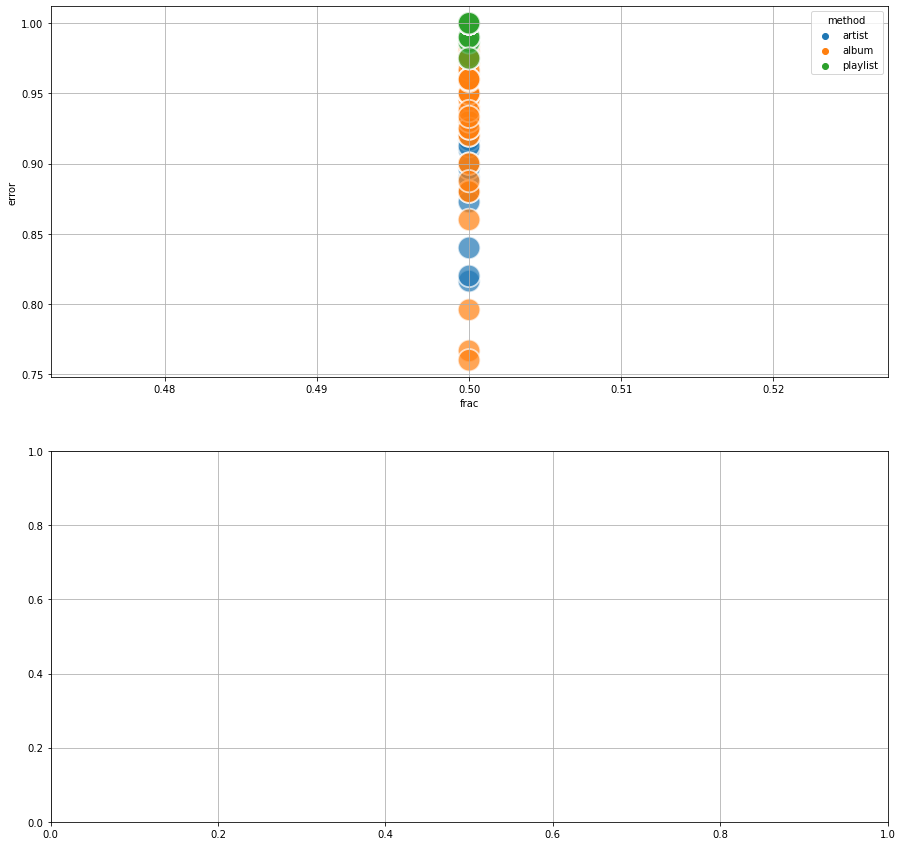

In [633]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15, 15))
sns.scatterplot(ax=axes[0], x='frac', y='error', data=results, s=500, alpha =0.7, hue='method');
# plt.y_label('Run time') #y label

# sns.scatterplot(ax=axes[1], x='run_time_mean', y='accuracy_mean', data=profiling_grid, s=500, alpha =0.7, hue='classifier');
# plt.xlabel('Mean run time') #y label
# plt.ylabel('Mean accuracy') #x label
# plt.grid()
plt.rcParams['axes.grid'] = True

#  Tests

In [ ]:
# # def get_trk_album2(playlist_trx, trx_train, trx_test, ref_fraction):
# #     trx_available, reference_trx, expected_trx = prepare_inputs(playlist_trx, trx_train, trx_test, ref_fraction)

# trx_freq = tracks_frequency[tracks_frequency.track_id.isin(trx_available['id'])]

# select = trx_freq.drop(trx_freq.index)

# while len(select) < len(expected_trx)*2:
#     rnd = random.uniform(0, 1)
#     for i, c in enumerate(trx_freq.cum_perc):
#         if rnd <= c:
#             select = select.append(trx_freq.iloc[i])
#             select = select.drop_duplicates()
#             break

# select = select[~select.track_id.isin(reference_trx['id'])]
# select = select.reset_index()
# select = select.iloc[0:len(expected_trx)]['track_id']

# selected_trx = trx_available[trx_available.id.isin(select)]

# return reference_trx, expected_trx, selected_trx

# # reference_trx, expected_trx, selected_trx = get_trk_strata(
# #     df_playlists_test['1h4bUPnrpgn8qXGJ5dvTsu'], df_tracks_train,
# #     df_tracks_test, .5)
# # print(len(reference_trx), len(expected_trx), len(selected_trx))
# # reference_trx, expected_trx, selected_trx

In [57]:
# def get_tracks_by_album_artist(data_path):
#     # check if data extraction already exists then load if it exists, otherwise run query
#     if os.path.exists(data_path + '9_tracks_by_artist.pkl') and os.path.exists(
#             data_path + '9_tracks_by_album.pkl'):
#         print('Tracks by album - Loaded: ' + data_path)
#         # load file only if the next step was not executed (getting tracks)
#         with open(data_path + '9_tracks_by_artist.pkl', 'rb') as f:
#             trx_by_artists = pickle.load(f)

#         print('Tracks by artist - Loaded: ' + data_path)
#         # load file only if the next step was not executed (getting tracks)
#         with open(data_path + '9_tracks_by_album.pkl', 'rb') as f:
#             trx_by_albums = pickle.load(f)
#     else:
#         trx_by_albums, trx_by_artists = tracks_by_album_artist()

#         # Save the data
#         print('Tracks by album - Saved: ' + data_path)
#         with open(data_path + '9_tracks_by_artist.pkl', 'wb') as f:
#             pickle.dump(trx_by_artists, f)

#         print('Tracks by artist - Saved: ' + data_path)
#         with open(data_path + '9_tracks_by_album.pkl', 'wb') as f:
#             pickle.dump(trx_by_albums, f)
#     return trx_by_albums, trx_by_artists

In [430]:
# def get_tracks_from_playlist_from_selected_album(pid, aid, ntid):
#     p = playlists_train.loc[pid].tracks
# #     p = p[~p['id']==ntid]
# #     print(type(p))
    
#     r = []
#     for i, tr in enumerate(p):
# #         print(i,tr)
#         if tr['album']['id'] == aid:
#             r.append(tr)
# #             tracks_matched.append(track['id'])
#     return r

In [460]:
# select = []
# for t, cur_trk in enumerate(reference_trx.T):
#     if t < 2:
#         #         print(t, cur_trk_album)
#         aid = reference_trx.loc[cur_trk].album['id']
#         print(t, 'tid:', cur_trk, 'aid: ')
        
# #         print(co_occurrence_albums_train[aid])
# #         print()
# #         for co_ocur_aid in co_occurrence_albums_train[aid].T:
#         print('AA')
#         co_ocur_aid = co_occurrence_albums_train[aid].iloc[1].name
# #         if co_ocur_aid != aid:
#         print('AAAAAAA')
#         print()
#         print('co_ocur aid:', co_ocur_aid)
#         #                 co_ocur_aid = co_occurrence_albums_train[aid].iloc[1].name
#         #                 print(co_ocur_aid)

# #                 playlists = random.sample(
# #                     albums_dict_train[co_ocur_aid]['in_playlist'],
# #                     len(albums_dict_train[co_ocur_aid]['in_playlist']))
#         playlist_id = random.sample(albums_dict_train[co_ocur_aid]['in_playlist'], 1)[0]
# #                 for playlist_id in playlists:
#         print('BBBBBBBB')
#         select = random.sample(get_tracks_from_playlist(playlist_id), 1)
# #                 selected = get_tracks_from_playlist_from_selected_album(
# #                     playlist_id, aid,cur_trk)

# #                 if len(selected) > 0:
# #                     select = random.sample(selected, 1)
# #                     print('break', select)
# #                     print()
# #                     break
# #                     else:
# #                         print(select)
# #             if len(select) > 0:
# #                 print('bbbbccccc')
# #                 break

# #         print('CCCCCCC')
# #         if len(select) > 0:
# #             break
# #         else:
# #             print('RRRRRRR')
# #             print('random')
# #             select = random.sample(get_tracks_from_playlist(playlist_id), 1)
        
# #         print('DDDDDDDDDD')
# #         print()
# #         if len(select) > 0:
# #             print('final', select)
# #             break

In [42]:
# artists_dict['72FGvJgYbs0NBeJqECy6cF']

In [43]:
# albums_dict['0a7qEtQgY7QvUyzJ6bcnlc']

In [44]:
# def tracks_by_album_artist():
#     albums = {}
#     artists = {}
#     cnt = 0
#     for t, tid in enumerate(tracks_dict):
# #         if t % 100 == 0:
# #                 print("%s - %d/%d - LEN: %d" %
# #                       (datetime.datetime.now().strftime(format), t, len(albums),
# #                        len(tracks_dict)))

# #         tr = {}

#         # Albums
#         alb = tracks_dict[tid]['album']['id']
#         if alb not in albums.keys():
#             tr = {}
#             tr['trx'] = [tid]
#             tr['cnt'] = [len(tracks_dict[tid]['in_playlist'])]
#             albums.update({alb: tr})
#         else:
#             curr_track = albums.get(alb)
#             curr_in_track = curr_track['trx'].copy()
#             curr_in_track.append(tid)
#             tr['trx'] = curr_in_track
#             aux_cnt = curr_track['cnt'].copy()
#             aux_cnt.append(len(tracks_dict[tid]['in_playlist']))
#             tr['cnt'] = aux_cnt
#             albums.update({alb: tr})

#         # Artists
# #         tr2 = {}
#         for artist in tracks_dict[tid]['artists']:
#             art = artist['id']
#             if art not in artists.keys():
#                 tr2 = {}
#                 tr2['trx'] = [tid]
#                 tr2['cnt'] = [len(tracks_dict[tid]['in_playlist'])]
#                 artists.update({art: tr2})
#                 if art == '72FGvJgYbs0NBeJqECy6cF':
#                     cnt = cnt + 1
#                     print(cnt, 'aid: ',art, 'tid: ', tid)
#                     print(tr2)
#                     print()
#             else:
#                 curr_track2 = {}
#                 curr_track2 = artists.get(art)
#                 curr_in_track2 = curr_track2['trx'].copy()
#                 if art == '72FGvJgYbs0NBeJqECy6cF':
#                     cnt = cnt + 1
#                     print(cnt, 'aid: ',art, 'tid: ', tid)
#                     print(curr_track2)
#                     print(curr_in_track2)
#                 curr_in_track2.append(tid)
#                 if art == '72FGvJgYbs0NBeJqECy6cF':
#                     print(curr_in_track2)
#                 tr2['trx'] = curr_in_track2
# #                 tr2['trx'] = curr_track2['trx'].copy().append(tid)
#                 aux_cnt2 = curr_track2['cnt'].copy()
#                 aux_cnt2.append(len(tracks_dict[tid]['in_playlist']))
#                 tr2['cnt'] = aux_cnt2
#                 artists.update({art: tr2})
                
#                 if art == '72FGvJgYbs0NBeJqECy6cF':
#                     print(curr_track2)
#                     print(curr_in_track2)
#                     print(tr2)
#                     print()
# #     print(artists['72FGvJgYbs0NBeJqECy6cF'])
# #                 print(artists)
# #         asdf = albums
# #         qwer = artists
#     return albums, artists

# # bkp = tracks_dict
# # tmp = {}
# # tmp.update({'1tx6cTPSabCIN0V90Hzlhc':tracks_dict['1tx6cTPSabCIN0V90Hzlhc']})
# # tmp.update({'2dKyeWBPwhqMfPetw8PiFg':tracks_dict['2dKyeWBPwhqMfPetw8PiFg']})

# # tracks_dict = tmp

# aaa, bbb = tracks_by_album_artist()

# # tracks_dict = bkp

# # aaa['72FGvJgYbs0NBeJqECy6cF']
# 

In [47]:
# bbb['72FGvJgYbs0NBeJqECy6cF']

In [45]:
# tracks_dict['0cWLJcdvM6QlOQ7UJdB4jb']

In [46]:
# tracks_dict['6St9ArMKEPj7KOSTEo29Ii']

In [48]:
# tracks_dict['1tx6cTPSabCIN0V90Hzlhc']

In [ ]:
# # reference_trx, expected_trx, 
# selected_trx = selected_trx.append(expected_trx[expected_trx['id'] == '0e3CM2Fm4cpDtxjzYkdLAr'])

# matches = selected_trx[selected_trx.id.isin(expected_trx.id)].id
# matches
# len(matches)

In [ ]:
# expected_trx

In [34]:
# reference_trx

In [35]:
# for t, trk in enumerate(reference_trx['id']):
#     if t == 0:
#         print(trk)
# #         print(reference_trx.T[trk].artists)
#         for a in reference_trx.T[trk].artists:
#             print(a)
#             print(a['id'])
# #             co_occurrence_artists_train[a.id]
            

In [36]:
# prepare_inputs_co_occur
# def prepare_inputs_co_occur(playlist_trx, trx_train, trx_test, fraction):
#     trx = playlist_trx.tracks
#     n = int((len(trx) + 1) * fraction)

#     ids = pd.DataFrame(trx).id  # ids of the original playlist
#     selected_ids = random.sample(ids.values.tolist(), n)

#     db = trx_train.T
#     trx_available = db[~db.id.isin(selected_ids)]

#     reference_trx = trx_test.T[trx_test.T.id.isin(selected_ids)]
#     expected_trx = trx_test.T[~trx_test.T.id.isin(selected_ids)
#                               & trx_test.T.id.isin(ids)]

#     return trx_available, reference_trx, expected_trx

In [58]:
# Tracks by albums and artists
# data_path = os.getcwd() + '\\data\\processed\\'
# trx_by_albums, trx_by_artists = get_tracks_by_album_artist(data_path)

# print('Albums: ', len(trx_by_albums))
# print('Artists: ', len(trx_by_artists))

In [59]:
# trx_by_artists['72FGvJgYbs0NBeJqECy6cF']

In [60]:
# trx_by_albums['0cTd2N7LixNrzfQuivSEmG']

In [61]:
# trx_by_artists['72FGvJgYbs0NBeJqECy6cF']

In [62]:
# tracks_dict

In [63]:
# tracks_dict['2dKyeWBPwhqMfPetw8PiFg']

In [64]:
# tracks_dict['1tx6cTPSabCIN0V90Hzlhc']

In [ ]:
# selected_trx

In [ ]:
# selected_trx.info()

In [ ]:
# for t, tid in enumerate(co_occurrence_tracks_train):
#     if t == 10:
#         df = co_occurrence_tracks_train[tid]
#         df['cum_sum'] = df['cnt'].cumsum()
#         df['cum_perc'] = 100*df['cum_sum']/df['cnt'].sum()
#         selector = random.sample(list(df.index),len(df))
#         print(selector)
#         print(len(selector))

#         cnt = 0
#         tot = 0
#         for i, item in enumerate(co_occurrence_tracks_train[tid]['cnt']):
#                 cnt = cnt + 1
#                 tot = tot + item
#         print(cnt)
#         print(tot)

In [ ]:
# def ranking(df,id_column):
#     single_list_temp = single_list(df[id_column])
#     data = {id_column: single_list_temp}
#     aux_df = pd.DataFrame(data)
    
#     name = id_column.replace('_id','_count')
#     ranked_sorted = aux_df.groupby([id_column]).agg(
#         temp_count=pd.NamedAgg(column=id_column, aggfunc="count")
#     )
#     ranked_sorted = ranked_sorted.rename(columns={'temp_count': name})
#     ranked_sorted = ranked_sorted.sort_values(name,ascending=False)
#     return ranked_sorted
# # ranking(df_test,'tracks_id')
# # print(tracks_rank)

# def top(ranked,n):
#     top_n = ranked.iloc[:n]
    
#     return top_n
# # tracks_rank = ranking(df_test,'tracks_id')
# # top(tracks_rank,10)
#     return ranked

# a = track_rank = ranking(df_test,'tracks_id')

In [ ]:
# df['cum_sum'] = df['cnt'].cumsum()
# df['cum_perc'] = 100*df['cum_sum']/co_occurrence_tracks_train['cnt'].sum()

In [ ]:
# matrix track x track
# track_rank = ranking(df_test,'tracks_id')
# s_tracks_id = list(track_rank.index)

# shape = [len(s_tracks_id), len(s_tracks_id)]
# track_matrix = np.zeros(shape, dtype=int, order='C')

# for i, row_track in enumerate(s_tracks_id):
#     row = s_tracks_id.index(row_track)
#     if i != row: print("i: " + str(i) + ": " + row_track), print()

#     for playlist in df_test['tracks_id']:
#         try:
#             check = playlist.index(row_track)
#         except ValueError:
#             #             print(row)
#             check = -1
#         if check >= 0:
#             for col_track in playlist:
#                 if col_track is not None:
#                     col = s_tracks_id.index(col_track)
#                     #                     print(col_track  + " - " + str(col))
#                     #                     tr = df_test['tracks'][n][col]
#                     #                     print("track: " + str(n) + ": " + col_track + " - col_match:" + str(col) + ": ") # + tr)
#                     track_matrix[row, col] += 1
# # print(track_matrix)